In [1]:
!pip install -q -U afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

import string
import re
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/MyDrive/Text Mining')
os.getcwd()

'/content/drive/MyDrive/Text Mining'

In [6]:
np.random.seed(42)

# Prepare dataset

In [7]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

# test2 = pd.read_csv('dataset/IMDB Dataset.csv', header=0, names=['reviews_content', 'category'])

# test2 = pd.read_csv('twitter_validation.csv', header=None)
# test2 = test2.iloc[1:, 2:]
# test2 = test2.rename(columns={2: 'category', 3: 'reviews_content'})

print('train head: ', train.shape)
print(train.head())
print('\n\ntest head: ', test.shape)
print(test.head())
# print('\n\ntest2 head: ', test2.shape)
# print(test2.head())

train head:  (1500, 2)
                                     reviews_content  category
0  airplane ! is considered among many to be the ...  positive
1  you've got to love disney . \nno matter what t...  positive
2   " the tailor of panama " is a different kind ...  positive
3  the characters in jonathan lynn's " the whole ...  negative
4  vikings v . bears ? \nno , this isn't the line...  negative


test head:  (500, 1)
                                     reviews_content
0  towards the middle of " the sweet hereafter , ...
1  wild things is a suspenseful thriller starring...
2  hong kong cinema has been going through a bad ...
3  while alex browning ( devon sawa ) waits at jf...
4  sometimes i find 19th century british costume ...


# EDA

In [45]:
positive_reviews = train[train['category'] == 1]
negative_reviews = train[train['category'] == 0]

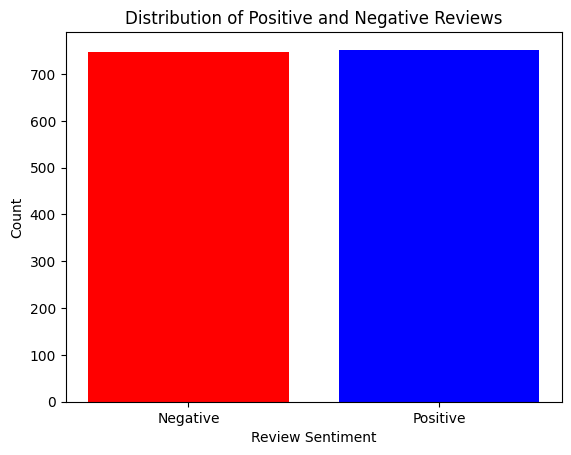

In [88]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'train' with a 'category' column (0 for negative, 1 for positive)
labels = ['Negative', 'Positive']

# Count the number of positive and negative reviews
negative_count = len(train[train['category'] == 0])
positive_count = len(train[train['category'] == 1])

# Set the x-axis positions for the bars
bar_positions = [0, 1]

# Plot the bars
plt.bar(bar_positions, [negative_count, positive_count], align='center', color=['red', 'blue'])

# Add labels and title
plt.xticks(bar_positions, labels)
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Positive and Negative Reviews')

# Display the plot
plt.show()

In [49]:
print(positive_reviews.shape)
print(negative_reviews.shape)

(752, 7)
(748, 7)


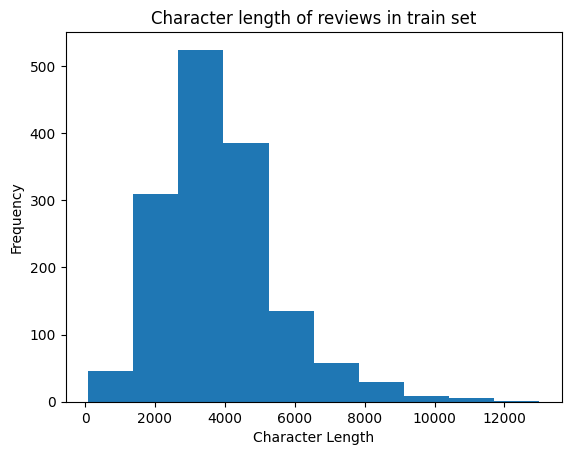

In [40]:
train['reviews_content'].str.len().hist()
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Character length of reviews in train set')
plt.grid(None)
plt.show()

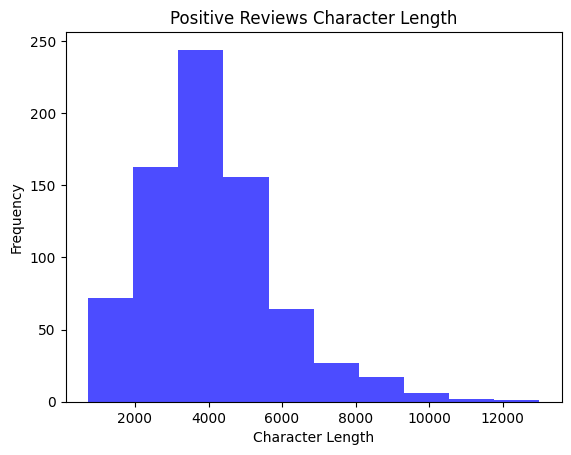

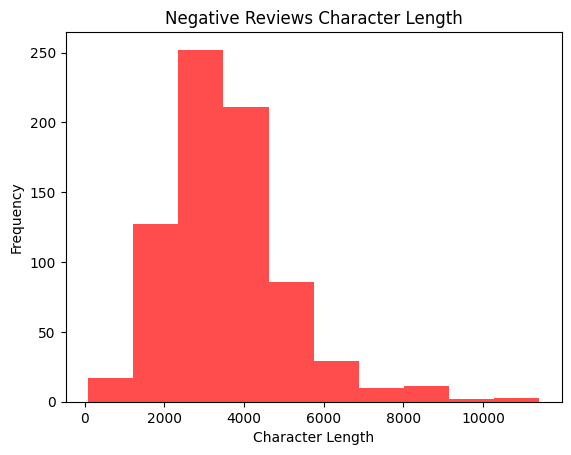

In [46]:
  # plt.figure(figsize=(10, 6))
plt.hist(positive_reviews['reviews_content'].str.len(), color='blue', alpha=0.7)
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Positive Reviews Character Length')
plt.show()

# plt.figure(figsize=(10, 6))
plt.hist(negative_reviews['reviews_content'].str.len(), color='red', alpha=0.7)
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Negative Reviews Character Length')
plt.show()

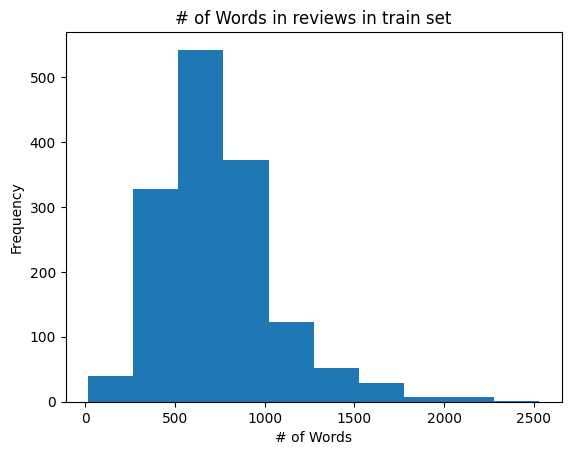

In [91]:
train['reviews_content'].str.split().map(lambda x: len(x)).hist()
plt.xlabel('# of Words')
plt.ylabel('Frequency')
plt.title('# of Words in reviews in train set')
plt.grid(None)
plt.show()

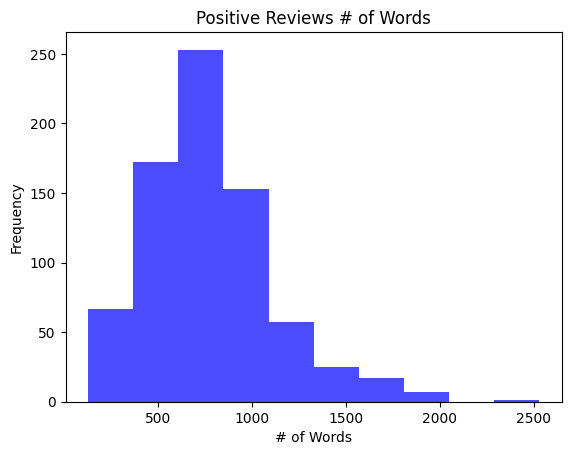

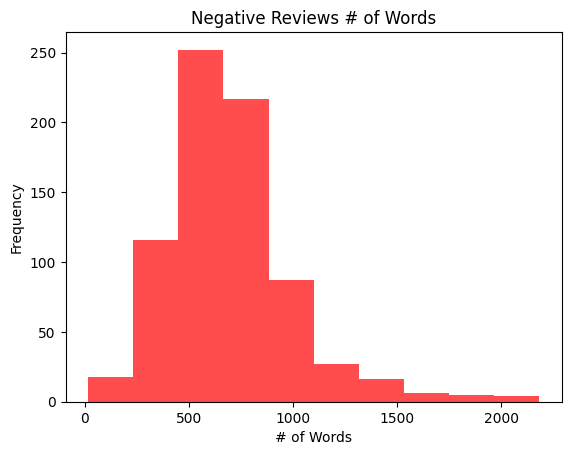

In [94]:
# plt.figure(figsize=(10, 6))
positive_reviews['reviews_content'].str.split().map(lambda x: len(x)).hist(color='blue', alpha=0.7)
plt.xlabel('# of Words')
plt.ylabel('Frequency')
plt.title('Positive Reviews # of Words')
plt.grid(None)
plt.show()

# plt.figure(figsize=(10, 6))
negative_reviews['reviews_content'].str.split().map(lambda x: len(x)).hist(color='red', alpha=0.7)
plt.xlabel('# of Words')
plt.ylabel('Frequency')
plt.title('Negative Reviews # of Words')
plt.grid(None)
plt.show()

## Preprocessing

In [9]:
# Remove blank if any
train['reviews_content'].dropna(inplace=True)
test['reviews_content'].dropna(inplace=True)

print('train shape: ')
print(train.shape)
print('\ntest shape: ')
print(test.shape)

train shape: 
(1500, 2)

test shape: 
(500, 1)


In [10]:
with open("dataset/EMOTICONS.txt") as f:
  content = f.read()

exec(content)

with open("dataset/EMO_UNICODE.txt") as f:
  content = f.read()

exec(content)

with open("dataset/chat_words_str.txt") as f:
  content = f.read()

exec(content)

In [130]:
def convert_emoticons(text):
  for emot in EMOTICONS:
    text = re.sub(u'(' +emot+ ')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
  return text

def convert_emojis(text):
  for emot in EMO_UNICODE:
    text = re.sub(u'(' +emot+ ')', "_".join(EMO_UNICODE[emot].replace(",","").replace(":","").split()), text)
  return text

chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

STOPWORDS = set(stopwords.words('english'))

def listbased_stopwords(sentence):

  filtered_text = [word for word in str(sentence).split() if word not in STOPWORDS]

  result_length = len(filtered_text)
  filtered_text = " ".join(filtered_text)

  return filtered_text

def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def preprocess(text: str) -> list:
    corpus = str(text).lower() # lowercase

    corpus = convert_emoticons(corpus)
    corpus = convert_emojis(corpus)
    corpus = chat_words_conversion(corpus)
    corpus = listbased_stopwords(corpus) # stopwords
    corpus = remove_html_tags(corpus) # remove html tag
    corpus = corpus.replace('\n', '').replace('\t', '') # replace \n \t

    # corpus = re.sub('[^a-zA-Z]+',' ', corpus).strip() # remove special characters
    # tokens = word_tokenize(corpus) # tokenize
    # words = [token for token in tokens if token not in stop_words] # remove stopwords
    # words = [lemmatizer.lemmatize(word) for word in words] # lemmatize
    return corpus

In [131]:
train['preprocessed'] = train['reviews_content'].apply(preprocess)
test['preprocessed'] = test['reviews_content'].apply(preprocess)

train['preprocessed'] = train['preprocessed'].apply(remove_html_tags)
test['preprocessed'] = test['preprocessed'].apply(remove_html_tags)

train['preprocessed'] = train['preprocessed'].str.replace('\n', '').str.replace('\t', '')
test['preprocessed'] = test['preprocessed'].str.replace('\n', '').str.replace('\t', '')

# Feature engineering

## Count positive and negative words

In [132]:
from afinn import Afinn

afinn = Afinn()

In [133]:
def count_sentiment(text):
    tokens = text.split()  # Tokenize the text
    positive_words = 0
    negative_words = 0
    for token in tokens:
        sentiment_score = afinn.score(token)
        if sentiment_score > 0:
            positive_words += 1
        elif sentiment_score < 0:
            negative_words += 1
    return positive_words, negative_words

In [134]:
train['pos_count'], train['neg_count'] = zip(*train['reviews_content'].apply(count_sentiment))
test['pos_count'], test['neg_count'] = zip(*test['reviews_content'].apply(count_sentiment))

In [135]:
train.head()

,reviews_content,category,preprocessed,pos_count,neg_count,total_len,sentiment
0,airplane ! is considered among many to be the ...,1,airplane ! considered among many epitome satir...,18,24,686,-0.01
1,you've got to love disney . \nno matter what t...,1,"got love disney . matter serve , guaranteed su...",52,30,1336,0.02
2,""" the tailor of panama "" is a different kind ...",1,""" tailor panama "" different kind spy movie . d...",45,21,885,0.03
3,"the characters in jonathan lynn's "" the whole ...",0,"characters jonathan lynn's "" whole nine yards ...",38,26,1129,0.01
4,"vikings v . bears ? \nno , this isn't the line...",0,"vikings v . bears ? , lineup monday night foot...",29,32,687,-0.00


## Count overall sentiment score

In [136]:
# count word length
def length_count(text):
  words=  text.split()
  num_words = len(words)
  return num_words

train['total_len'] = train['reviews_content'].apply(length_count)
test['total_len'] = test['reviews_content'].apply(length_count)

In [137]:
train.head()

,reviews_content,category,preprocessed,pos_count,neg_count,total_len,sentiment
0,airplane ! is considered among many to be the ...,1,airplane ! considered among many epitome satir...,18,24,686,-0.01
1,you've got to love disney . \nno matter what t...,1,"got love disney . matter serve , guaranteed su...",52,30,1336,0.02
2,""" the tailor of panama "" is a different kind ...",1,""" tailor panama "" different kind spy movie . d...",45,21,885,0.03
3,"the characters in jonathan lynn's "" the whole ...",0,"characters jonathan lynn's "" whole nine yards ...",38,26,1129,0.01
4,"vikings v . bears ? \nno , this isn't the line...",0,"vikings v . bears ? , lineup monday night foot...",29,32,687,-0.00


sentiment score: (pos + neg)/ total length

In [138]:
train['sentiment'] = round((train['pos_count'] - train['neg_count']) / train['total_len'], 2)
test['sentiment'] = round((test['pos_count'] - test['neg_count']) / test['total_len'], 2)

In [139]:
train.head()

,reviews_content,category,preprocessed,pos_count,neg_count,total_len,sentiment
0,airplane ! is considered among many to be the ...,1,airplane ! considered among many epitome satir...,18,24,686,-0.01
1,you've got to love disney . \nno matter what t...,1,"got love disney . matter serve , guaranteed su...",52,30,1336,0.02
2,""" the tailor of panama "" is a different kind ...",1,""" tailor panama "" different kind spy movie . d...",45,21,885,0.03
3,"the characters in jonathan lynn's "" the whole ...",0,"characters jonathan lynn's "" whole nine yards ...",38,26,1129,0.01
4,"vikings v . bears ? \nno , this isn't the line...",0,"vikings v . bears ? , lineup monday night foot...",29,32,687,-0.00


# Building SVM

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

In [141]:
vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.8,
    sublinear_tf=True,
    use_idf=True,
)

train_vectors = vectorizer.fit_transform(train['preprocessed'])
test_vectors = vectorizer.transform(test['preprocessed'])

In [142]:
# For no feature engineering
train_features = train_vectors
test_features = test_vectors

In [107]:
# Normlize the features
scaler = StandardScaler()
train_numerical_features = scaler.fit_transform(train[['pos_count', 'neg_count', 'sentiment']])
test_numerical_features = scaler.transform(test[['pos_count', 'neg_count', 'sentiment']])

# Combine the text and features
train_features = hstack([train_vectors, train_numerical_features])
test_features = hstack([test_vectors, test_numerical_features])

In [149]:
train_numerical_features

array([[-0.64413193,  0.18637053, -0.93235914],
       [ 1.83423311,  0.70168075,  0.74521628],
       [ 1.32398148, -0.07128458,  1.30440809],
       ...,
       [-1.08149047, -1.01601999, -0.37316733],
       [-1.37306283, -1.01601999, -0.93235914],
       [ 1.25108839,  2.84880668, -0.93235914]])

In [143]:
# Split data
train_length = int(train_features.shape[0] * 0.9)
train_data = train_features.toarray()[:train_length, :]
val_data = train_features.toarray()[train_length:, :]

print('train shape: ', train_data.shape)
print('val shape: ', val_data.shape)

train shape:  (1350, 11036)
val shape:  (150, 11036)


In [144]:
# Encode the label
le = LabelEncoder()
train['category'] = le.fit_transform(train['category'])

train_label = train['category'].iloc[:train_length]
val_label = train['category'].iloc[train_length:]

In [145]:
import time
from sklearn import svm
from sklearn.metrics import classification_report

In [146]:
# # parameter searching
# from sklearn.model_selection import GridSearchCV

# svm_clf = svm.SVC(kernel='linear')

# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [0.001, 0.01, 0.1, 1, 10]}

# grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='f1_macro')
# grid_search.fit(train_data, train_label)

# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [147]:
classifier_linear = svm.SVC(kernel='linear', class_weight='balanced', C=1, gamma=0.001)
t0 = time.time()

classifier_linear.fit(train_data, train_label)
t1 = time.time()

prediction_linear = classifier_linear.predict(val_data)
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1

print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

Training time: 19.289167s; Prediction time: 1.892962s


# Result

In [110]:
# with feature engineering

from sklearn.metrics import accuracy_score
print(accuracy_score(val_label, prediction_linear))

0.8466666666666667


In [128]:
# without feature engineering

from sklearn.metrics import accuracy_score
print(accuracy_score(val_label, prediction_linear))

0.8933333333333333


In [124]:
test_features.shape

(500, 10917)

In [125]:
output_pred = le.inverse_transform(classifier_linear.predict(test_features.toarray()))

In [127]:
output_files = pd.DataFrame({'Row': range(1, 501), 'Label': output_pred})
output_files

,Row,Label
0,1,positive
1,2,positive
2,3,positive
3,4,negative
4,5,positive
...,...,...
495,496,positive
496,497,positive
497,498,positive
498,499,positive


In [129]:
output_files.to_csv('output_svm final without feature engineering.csv', index=False)